In [70]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import time
import random
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense



Load data

In [71]:
final_dataframes = pd.read_pickle('/Users/niklasandersen/Documents/GitHub/P5/data_prep/one_year.pkl')
four_days = pd.read_pickle('/Users/niklasandersen/Documents/Github/P5/data_prep/four_days_data.pkl')

In [72]:
# Check for NaN values in each DataFrame in final_dataframes
nan_exists = False
for key, df in final_dataframes.items():
    if df.isnull().values.any():
        print(f"NaN values found in DataFrame with key: {key}")
        nan_exists = True

if not nan_exists:
    print("No NaN values found in any DataFrame.")
# Print the shape of a dataframe from final_dataframes
# Replace 'your_key' with the actual key of the dataframe you want to check
key = list(final_dataframes.keys())[0]  # Example: get the first key
print(f"Shape of the dataframe with key '{key}': {final_dataframes[key].shape}")

No NaN values found in any DataFrame.
Shape of the dataframe with key '(549360.0, 6330576.0)': (34449, 6)


In [73]:
# Check for NaN values in each DataFrame in final_dataframes
nan_exists = False
for key, df in four_days.items():
    if df.isnull().values.any():
        print(f"NaN values found in DataFrame with key: {key}")
        nan_exists = True

if not nan_exists:
    print("No NaN values found in any DataFrame.")
# Print the shape of a dataframe from final_dataframes
# Replace 'your_key' with the actual key of the dataframe you want to check
key1 = list(four_days.keys())[0]  # Example: get the first key
print(f"Shape of the dataframe with key '{key1}': {four_days[key1].shape}")


No NaN values found in any DataFrame.
Shape of the dataframe with key '(549360.0, 6330576.0)': (384, 6)


Data prep

In [74]:
# Define the train ratio
train_ratio = 0.7  # 80% training data
lookback = 50
pred_horizon = 5
df_dict = final_dataframes

# Split each DataFrame into training and testing parts based on time
df_dict_train = {}
df_dict_test = {}
for key, df in final_dataframes.items():
    n_time_steps = len(df['traffic_flow'])
    train_size = int(n_time_steps * train_ratio)
    df_train = df.iloc[:train_size].copy()
    df_test = df.iloc[train_size:].copy()
    df_dict_train[key] = df_train
    df_dict_test[key] = df_test

In [75]:
# Define the train ratio
train_ratio = 0.7  # 80% training data
lookback = 50
pred_horizon = 5
#df_dict = final_dataframes


def split_data(data, train_ratio=0.7):
    df_dict_train = {}
    df_dict_test = {}
    for key, df in data.items():
        n_time_steps = len(df['traffic_flow'])
        train_size = int(n_time_steps * train_ratio)
        df_train = df.iloc[:train_size].copy()
        df_test = df.iloc[train_size:].copy()
        df_dict_train[key] = df_train
        df_dict_test[key] = df_test
    return train_size, df_train, df_test, df_dict_train, df_dict_test

train_size, df_train, df_test, df_dict_train, df_dict_test = split_data(final_dataframes, train_ratio=0.7)
train_size4, df_train4, df_test4, df_dict_train4, df_dict_test4 = split_data(four_days, train_ratio=0.7)

In [76]:
print(train_size, train_size4)

24114 268


In [77]:

def create_sliding_window_data(df_dict, lookback, pred_horizon):
    X_dict = {}
    y_dict = {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node = []
        y_node = []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i + lookback])  # Input: Lookback window
            y_node.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict

# Generate sliding window data for training and testing sets
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)

Largest component

In [78]:
def clean_graph(graph):
    # Remove self-loops
    graph = graph.copy()  # Avoid modifying the
    self_loops = list(nx.selfloop_edges(graph))
    graph.remove_edges_from(self_loops)
    
    # Remove duplicate edges (not necessary for undirected graphs in NetworkX)
    # Here just in case your graph is directed or you need further verification
    edges_to_remove = []
    for u, v, data in graph.edges(data=True):
        if graph.number_of_edges(u, v) > 1:  # More than one edge exists
            edges_to_remove.append((u, v))
    
    graph.remove_edges_from(edges_to_remove)
    largest_component = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_component)

    print(f"Removed {len(self_loops)} self-loops and {len(edges_to_remove)} duplicate edges. Choose the Largest Component: {len(largest_component)} nodes.")
    # extract largest component

    return graph


Graph metrics

In [79]:
def analyze_graph(graph):
    """
    Analyze a graph and return detailed metrics and properties.

    Parameters:
        graph (networkx.Graph): The graph to analyze.

    Returns:
        dict: A dictionary containing the graph's metrics and properties.
    """
    if not isinstance(graph, nx.Graph):
        raise TypeError("The input must be a NetworkX graph.")

    # Ensure the graph is not empty
    if graph.number_of_nodes() == 0:
        return {"error": "The graph is empty."}

    analysis = {}

    # Basic Graph Properties
    analysis['num_nodes'] = graph.number_of_nodes()
    analysis['num_edges'] = graph.number_of_edges()
    analysis['density'] = nx.density(graph)
    analysis['is_directed'] = nx.is_directed(graph)

    # Degree Properties
    degrees = [degree for _, degree in graph.degree()]
    analysis['average_degree'] = np.mean(degrees)
    analysis['degree_distribution'] = degrees

    # Centrality Measures
    analysis['degree_centrality'] = nx.degree_centrality(graph)
    analysis['betweenness_centrality'] = nx.betweenness_centrality(graph)
    analysis['closeness_centrality'] = nx.closeness_centrality(graph)
    analysis['eigenvector_centrality'] = nx.eigenvector_centrality(graph, max_iter=1000)

    # Path and Connectivity
    if nx.is_connected(graph):
        analysis['average_shortest_path_length'] = nx.average_shortest_path_length(graph)
        analysis['diameter'] = nx.diameter(graph)
    else:
        analysis['average_shortest_path_length'] = "Graph is not connected."
        analysis['diameter'] = "Graph is not connected."

    # Clustering
    analysis['clustering_coefficient'] = nx.clustering(graph)
    analysis['average_clustering'] = nx.average_clustering(graph)

    # Components
    components = list(nx.connected_components(graph)) if not nx.is_directed(graph) else list(nx.strongly_connected_components(graph))
    analysis['num_components'] = len(components)
    analysis['largest_component_size'] = max(len(comp) for comp in components)

    # Assortativity
    analysis['degree_assortativity_coefficient'] = nx.degree_assortativity_coefficient(graph)

    # Power-Law Fit for Degree Distribution
    try:
        power_law_fit = np.polyfit(np.log(range(1, len(degrees) + 1)), np.log(sorted(degrees, reverse=True)), 1)
        analysis['power_law_exponent'] = -power_law_fit[0]
    except Exception:
        analysis['power_law_exponent'] = "Could not compute power-law fit."

    # Subgraph Analysis
    analysis['triangles'] = nx.triangles(graph)
    analysis['num_triangles'] = sum(nx.triangles(graph).values()) // 3

    # Spectral Properties
    laplacian_matrix = nx.laplacian_matrix(graph).toarray()
    eigenvalues = np.linalg.eigvals(laplacian_matrix)
    analysis['laplacian_eigenvalues'] = sorted(eigenvalues)

    return analysis


Correlation graph based off of np.corrcoef

In [80]:
def create_correlation_graph(df_dict_full, df_dict_train, threshold=0.5, weighted=False, degree=31):
    """
    Create a correlation graph with a maximum degree constraint using only the training data for correlations.
    """
    correlation_graph = nx.Graph()
    correlations_dict = {}

    # Add nodes to the graph using the full data
    for key, df in df_dict_full.items():
        correlation_graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow=df['traffic_flow'].values  # Full traffic data
        )

    # Calculate correlations using the training data
    for key1, df1_train in df_dict_train.items():
        for key2, df2_train in df_dict_train.items():
            if key1 >= key2:  # Avoid duplicate computations
                continue
            correlation = np.corrcoef(df1_train['traffic_flow'], df2_train['traffic_flow'])[0, 1]
            correlations_dict[key1, key2] = correlation
            correlations_dict[key2, key1] = correlation  # Symmetric for undirected graph

    # Add edges based on correlation, enforcing degree constraint
    for key1 in df_dict_full.keys():
        # Sort potential connections by correlation (highest first)
        potential_edges = [
            (key2, correlations_dict[key1, key2])
            for key2 in df_dict_full.keys() if key1 != key2 and (key1, key2) in correlations_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])  # Sort by descending correlation

        for key2, corr in potential_edges:
            if correlation_graph.degree[key1] < degree and correlation_graph.degree[key2] < degree:
                if corr > threshold:
                    if weighted:
                        correlation_graph.add_edge(key1, key2, weight=corr)
                    else:
                        correlation_graph.add_edge(key1, key2)

    # Clean graph
    correlation_graph = clean_graph(correlation_graph)
    return correlation_graph, correlations_dict

Distance graph eucleadian distance

In [81]:
def create_distance_graph(df_dict, weighted=False, degree=4, clean = True):
    """
    Create a distance graph with a maximum degree constraint.
    """
    distance_graph = nx.Graph()
    distance_dict = {}

    # Add nodes to the graph
    for key, df in df_dict.items():
        distance_graph.add_node(
            key, 
            x=df['Xkoordinat'].iloc[0], 
            y=df['Ykoordinat'].iloc[0], 
            traffic_flow=df['traffic_flow'].values
        )

    # Calculate distances and store in a dictionary
    for key1, df1 in df_dict.items():
        for key2, df2 in df_dict.items():
            if key1 == key2:
                continue
            idx = df1['traffic_flow'].first_valid_index()
            distance = math.sqrt(
                (df1['Xkoordinat'][idx] - df2['Xkoordinat'][idx])**2 +
                (df1['Ykoordinat'][idx] - df2['Ykoordinat'][idx])**2
            )
            distance_dict[key1, key2] = distance

    # Add edges based on distance, enforcing degree constraint
    threshold = (sum(distance_dict.values()) / len(distance_dict)) * 2  # Distance threshold
    for key1 in df_dict.keys():
        # Sort potential connections by distance (shortest first)
        potential_edges = [
            (key2, distance_dict[key1, key2])
            for key2 in df_dict.keys() if key1 != key2 and (key1, key2) in distance_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: x[1])  # Sort by ascending distance
        
        for key2, dist in potential_edges:
            if distance_graph.degree[key1] < degree and distance_graph.degree[key2] < degree:
                if dist < threshold:
                    if weighted:
                        max_distance = max(distance_dict.values())
                        min_distance = min(distance_dict.values())
                        normalised_distance = (dist - min_distance) / (max_distance - min_distance)
                        distance_graph.add_edge(key1, key2, weight=normalised_distance)
                    else:
                        distance_graph.add_edge(key1, key2)

    # Clean graph
    if clean == True:
        distance_graph = clean_graph(distance_graph)
    return distance_graph, distance_dict


Fully connected graph

In [82]:
def create_fully_connected_graph(df_dict):
    # Connect every node to every other node without weights 
    fully_connected_graph = nx.complete_graph(len(df_dict))

    # Add attributes to the nodes
    for i, (key, df) in enumerate(df_dict.items()):
        fully_connected_graph.nodes[i]['x'] = df['Xkoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['y'] = df['Ykoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['traffic_flow'] = df['traffic_flow'].values
        
    return fully_connected_graph

Randomly genereated graph

In [83]:
def connect_nodes_with_erdos_renyi(df_dict, p, seed=None):
    np.random.seed(seed)
    num_nodes = len(df_dict)
    
    # Create an empty graph
    er_graph = nx.Graph()
    
    # Add nodes with attributes
    for i, (key, df) in enumerate(df_dict.items()):
        er_graph.add_node(i, 
                          x=df['Xkoordinat'].iloc[0], 
                          y=df['Ykoordinat'].iloc[0], 
                          traffic_flow=df['traffic_flow'].values)
    
    # Add edges using the ER model
    for u in er_graph.nodes:
        for v in er_graph.nodes:
            if u < v and np.random.rand() < p:
                er_graph.add_edge(u, v, weight=np.random.rand())
    
    # Get edge weights
    edge_weights = nx.get_edge_attributes(er_graph, 'weight')
    
    return er_graph, edge_weights

Auto encoded features for graph

# Exploring distance graphs

In [84]:
distance_graph_weighted, distance_dict = create_distance_graph(final_dataframes, weighted=True, degree=5)
distance_graph_unweighted, _ = create_distance_graph(final_dataframes, weighted=False, degree=5, )

Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 31 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 31 nodes.


/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_2274/3872167762.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


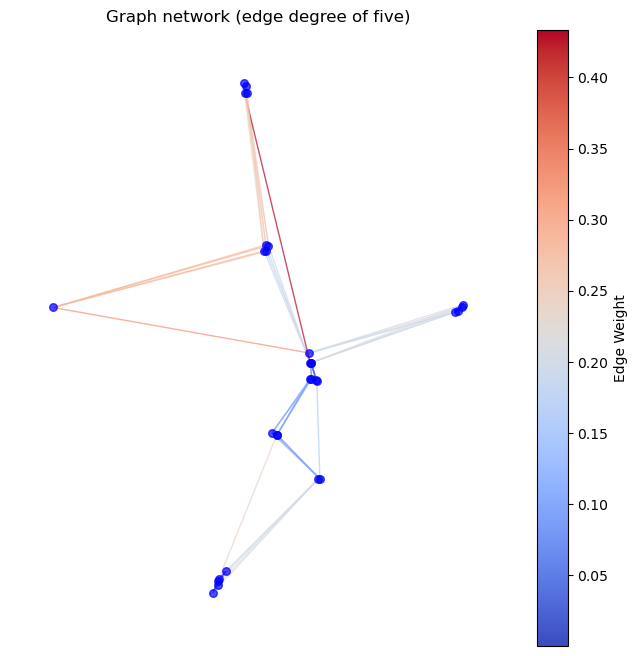

In [85]:
# Create a dictionary of node positions
pos2 = {node: (data['x'], data['y']) for node, data in distance_graph_weighted.nodes(data=True)}

# Extract edge weights
edge_weights = nx.get_edge_attributes(distance_graph_weighted, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    distance_graph_weighted,
    pos2,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights),
    edge_vmax=max(edge_weights),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Graph network (edge degree of five)")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [86]:
# Analyze the graph
graph_metrics = analyze_graph(distance_graph_weighted)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

num_nodes: 31
num_edges: 77
density: 0.16559139784946236
is_directed: False
average_degree: 4.967741935483871
degree_distribution: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5]
degree_centrality: {(549360.0, 6330576.0): 0.16666666666666666, (555132.0, 6317792.0): 0.16666666666666666, (555308.0, 6318304.0): 0.16666666666666666, (555292.0, 6318128.0): 0.16666666666666666, (555588.0, 6318742.0): 0.16666666666666666, (558928.0, 6322894.0): 0.16666666666666666, (558981.0, 6322888.0): 0.16666666666666666, (555341.0, 6318418.0): 0.16666666666666666, (557255.0, 6324952.0): 0.16666666666666666, (557437.0, 6324871.0): 0.16666666666666666, (557426.0, 6324854.0): 0.16666666666666666, (558870.0, 6327287.0): 0.16666666666666666, (563949.0, 6330413.0): 0.16666666666666666, (564139.0, 6330707.0): 0.16666666666666666, (564096.0, 6330582.0): 0.16666666666666666, (558845.0, 6327312.0): 0.16666666666666666, (563847.0, 6330375.0): 0.16666666666666666, (558649

# Exploring fully connected graphs

In [87]:
fully_connected_graph = create_fully_connected_graph(final_dataframes)

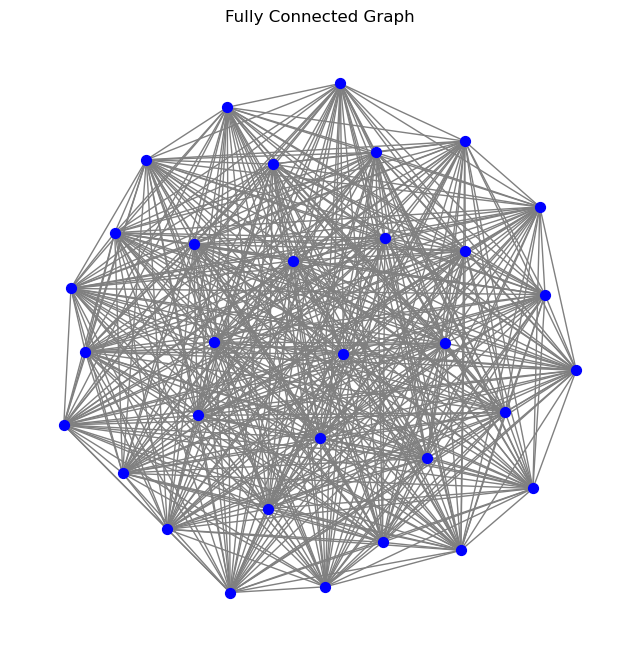

In [88]:
plt.figure(figsize=(8, 8))
plt.title("Fully Connected Graph")
pos = nx.spring_layout(fully_connected_graph)
nx.draw(fully_connected_graph, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.show()

In [89]:
# Analyze the graph
graph_metrics = analyze_graph(fully_connected_graph)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

num_nodes: 32
num_edges: 496
density: 1.0
is_directed: False
average_degree: 31.0
degree_distribution: [31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
degree_centrality: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0}
betweenness_centrality: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0}
closeness_centrality: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 1

/opt/anaconda3/lib/python3.12/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


# Exploring random generated graphs

In [90]:
fully_connected_graph_RANDOM_WEIGHTS, fully_connected_weights = connect_nodes_with_erdos_renyi(final_dataframes, p=0.5 ,seed=42)

/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_2274/315109979.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


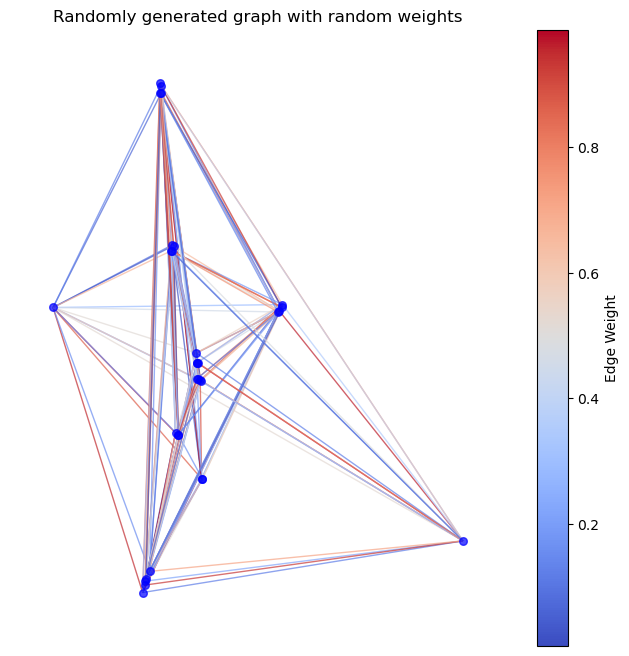

In [91]:
# Create a dictionary of node positions for the fully connected graph
pos3 = {node: (data['x'], data['y']) for node, data in fully_connected_graph_RANDOM_WEIGHTS.nodes(data=True)}

# Extract edge weights from the fully connected graph
edge_weights = nx.get_edge_attributes(fully_connected_graph_RANDOM_WEIGHTS, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    fully_connected_graph_RANDOM_WEIGHTS,
    pos3,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights),
    edge_vmax=max(edge_weights),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Randomly generated graph with random weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_2274/1312760439.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


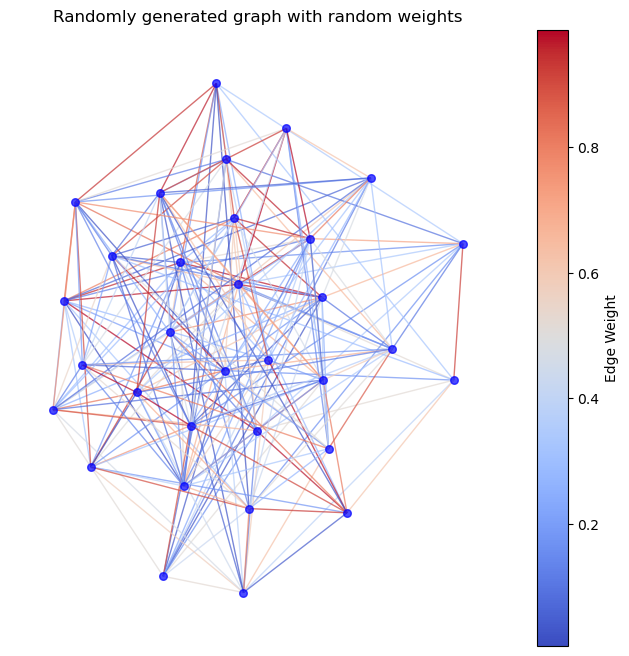

In [92]:
# Generate positions using spring layout
pos4 = nx.spring_layout(fully_connected_graph_RANDOM_WEIGHTS, seed=42)  # seed ensures reproducibility

# Extract edge weights
edge_weights = nx.get_edge_attributes(fully_connected_graph_RANDOM_WEIGHTS, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    fully_connected_graph_RANDOM_WEIGHTS,
    pos4,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights),
    edge_vmax=max(edge_weights),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Randomly generated graph with random weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [93]:
# Analyze the graph
graph_metrics = analyze_graph(fully_connected_graph_RANDOM_WEIGHTS)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

num_nodes: 32
num_edges: 227
density: 0.4576612903225806
is_directed: False
average_degree: 14.1875
degree_distribution: [17, 14, 12, 20, 11, 11, 8, 13, 16, 15, 13, 16, 12, 15, 11, 14, 14, 10, 18, 12, 16, 14, 17, 13, 14, 15, 13, 15, 14, 16, 17, 18]
degree_centrality: {0: 0.5483870967741935, 1: 0.45161290322580644, 2: 0.3870967741935484, 3: 0.6451612903225806, 4: 0.3548387096774194, 5: 0.3548387096774194, 6: 0.25806451612903225, 7: 0.4193548387096774, 8: 0.5161290322580645, 9: 0.4838709677419355, 10: 0.4193548387096774, 11: 0.5161290322580645, 12: 0.3870967741935484, 13: 0.4838709677419355, 14: 0.3548387096774194, 15: 0.45161290322580644, 16: 0.45161290322580644, 17: 0.3225806451612903, 18: 0.5806451612903225, 19: 0.3870967741935484, 20: 0.5161290322580645, 21: 0.45161290322580644, 22: 0.5483870967741935, 23: 0.4193548387096774, 24: 0.45161290322580644, 25: 0.4838709677419355, 26: 0.4193548387096774, 27: 0.4838709677419355, 28: 0.45161290322580644, 29: 0.5161290322580645, 30: 0.54838709

# Exploring correlation graphs

In [94]:
correlation_graph_weighted, correlation_dict = create_correlation_graph(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.7, weighted=True, degree=31)
correlation_graph_unweighted, _ = create_correlation_graph(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.7, weighted=False, degree=31)

Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 31 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 31 nodes.


/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_2274/1097515505.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


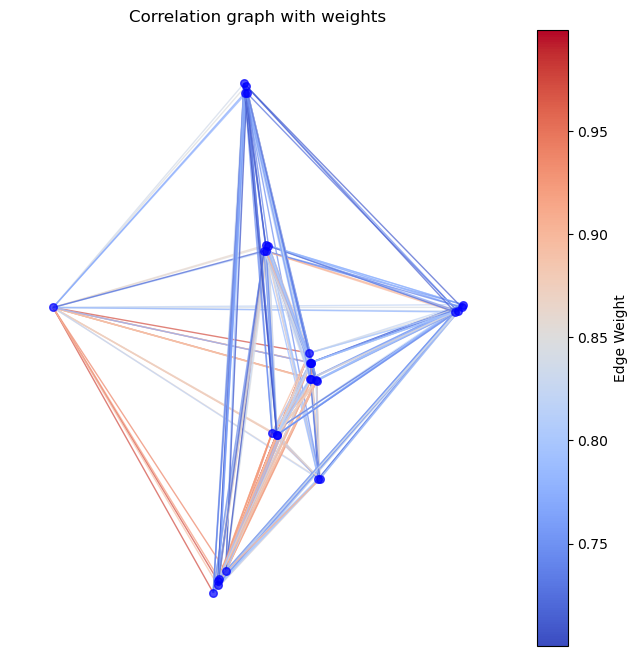

In [95]:
# Create a dictionary of node positions for the fully connected graph
pos5 = {node: (data['x'], data['y']) for node, data in correlation_graph_weighted.nodes(data=True)}

# Extract edge weights from the fully connected graph
edge_weights = nx.get_edge_attributes(correlation_graph_weighted, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    correlation_graph_weighted,
    pos5,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights),
    edge_vmax=max(edge_weights),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Correlation graph with weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_2274/3930158524.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


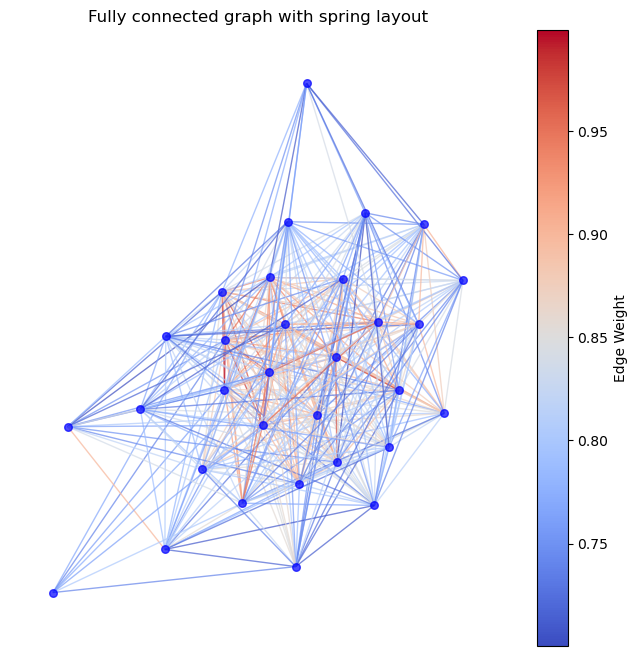

In [96]:
# Generate positions using spring layout
pos6 = nx.spring_layout(correlation_graph_weighted, seed=42)  # seed ensures reproducibility

# Extract edge weights
edge_weights = nx.get_edge_attributes(correlation_graph_weighted, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    correlation_graph_weighted,
    pos6,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights),
    edge_vmax=max(edge_weights),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Fully connected graph with spring layout")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [97]:
# Analyze the graph
graph_metrics = analyze_graph(correlation_graph_weighted)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

num_nodes: 31
num_edges: 379
density: 0.8150537634408602
is_directed: False
average_degree: 24.451612903225808
degree_distribution: [30, 30, 30, 28, 29, 24, 24, 28, 27, 26, 28, 26, 22, 24, 26, 28, 19, 30, 30, 26, 27, 11, 22, 21, 22, 26, 26, 21, 25, 7, 15]
degree_centrality: {(549360.0, 6330576.0): 1.0, (555132.0, 6317792.0): 1.0, (555308.0, 6318304.0): 1.0, (555292.0, 6318128.0): 0.9333333333333333, (555588.0, 6318742.0): 0.9666666666666667, (558928.0, 6322894.0): 0.8, (558981.0, 6322888.0): 0.8, (555341.0, 6318418.0): 0.9333333333333333, (557255.0, 6324952.0): 0.9, (557437.0, 6324871.0): 0.8666666666666667, (557426.0, 6324854.0): 0.9333333333333333, (558870.0, 6327287.0): 0.8666666666666667, (563949.0, 6330413.0): 0.7333333333333333, (564139.0, 6330707.0): 0.8, (564096.0, 6330582.0): 0.8666666666666667, (558845.0, 6327312.0): 0.9333333333333333, (563847.0, 6330375.0): 0.6333333333333333, (558649.0, 6328099.0): 1.0, (558595.0, 6328535.0): 1.0, (558676.0, 6327380.0): 0.8666666666666667,

### Exploring auto encoded feature graphs

In [98]:
import numpy as np
import networkx as nx
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

def process_and_create_correlation_graph(df_dict_full, df_dict_train, threshold=0.5, encoding_dim=50, epochs=100, batch_size=128):
    def autoencode_column(data, encoding_dim, epochs, batch_size):
        """Autoencode the column data."""
        data = np.array(data).reshape(-1, 1)  # Ensure proper shape
        input_dim = data.shape[1]
        
        # Normalize data
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)

        def build_autoencoder(input_dim, encoding_dim):
            input_layer = Input(shape=(input_dim,))
            encoded = Dense(128, activation='relu')(input_layer)
            encoded = Dense(64, activation='relu')(encoded)
            encoded = Dropout(0.2)(encoded)  # Prevent overfitting
            encoded = Dense(encoding_dim, activation='relu')(encoded)
            decoded = Dense(64, activation='relu')(encoded)
            decoded = Dense(128, activation='relu')(decoded)
            decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Use 'linear' for normalized input
            autoencoder = Model(inputs=input_layer, outputs=decoded)
            return autoencoder, input_layer, encoded

        autoencoder, input_layer, encoded = build_autoencoder(input_dim, encoding_dim)

        # Learning rate scheduler
        lr_scheduler = ReduceLROnPlateau(
            monitor='loss', 
            factor=0.5, 
            patience=3, 
            min_lr=1e-6, 
            verbose=0
        )
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss', 
            patience=20, 
            restore_best_weights=True, 
            verbose=0
        )
        
        # Compile and train autoencoder
        autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
        autoencoder.fit(
            data, data, 
            epochs=epochs, 
            batch_size=min(batch_size, len(data)), 
            shuffle=True, 
            verbose=1, 
            callbacks=[lr_scheduler, early_stopping]
        )
        
        # Extract encoded data
        encoder = Model(inputs=input_layer, outputs=encoded)
        encoded_data = encoder.predict(data)
        return encoded_data  # Return as 2D array

    # Process traffic flow data in both dictionaries
    for df_dict in [df_dict_full, df_dict_train]:
        for key, df in df_dict.items():
            if 'traffic_flow' in df.columns:
                df['traffic_flow_encoded'] = list(autoencode_column(df['traffic_flow'].values, encoding_dim, epochs, batch_size))

    # Create correlation graph
    correlation_graph = nx.Graph()
    keys = list(df_dict_full.keys())

    # Add nodes
    for key, df in df_dict_full.items():
        correlation_graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow_encoded=df['traffic_flow_encoded'],
        )

    # Precompute pairwise correlations
    encoded_data_matrix = []
    for key in keys:
        encoded_data = np.array(df_dict_full[key]['traffic_flow_encoded'].tolist())  # Ensure it's a 2D array
        encoded_data_matrix.append(encoded_data)

    # Stack all encoded data into a single matrix
    encoded_data_matrix = np.vstack(encoded_data_matrix)  # Combine all rows into one matrix

    # Check the shape of the resulting matrix
    print(f"Encoded data matrix shape: {encoded_data_matrix.shape}")

    # Compute correlation matrix
    correlation_matrix = np.corrcoef(encoded_data_matrix, rowvar=False)

    # Add edges
    for i, key1 in enumerate(keys):
        for j, key2 in enumerate(keys):
            if i >= j:
                continue
            similarity = correlation_matrix[i, j]
            if np.isnan(similarity) or similarity <= threshold:
                continue
            correlation_graph.add_edge(key1, key2, weight=similarity)
    
    return correlation_graph


In [99]:
encoded_graph = process_and_create_correlation_graph(final_dataframes, df_dict_train, threshold=0.5, encoding_dim=100, epochs=100, batch_size=512)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0229 - learning_rate: 0.0100
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2603e-04 - learning_rate: 0.0100
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3458e-04 - learning_rate: 0.0100
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4367e-05 - learning_rate: 0.0100
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2513e-04 - learning_rate: 0.0100
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2780e-05 - learning_rate: 0.0100
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9911e-05 - learning_rate: 0.0050
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5047e-05 - learning_rate: 0.0050
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1883e-05 - learning_rate: 0.0050
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8686e-05 - learning_rate: 0.0050
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7

In [103]:
print("Min weight:", min(edge_weights))
print("Max weight:", max(edge_weights))
print("Weights:", list(edge_weights))


Min weight: 0.5009188237344612
Max weight: 0.871093849847064
Weights: [0.5046838506387948, 0.6414616595160778, 0.5512009174533036, 0.641293303418758, 0.8005910846939046, 0.5897549543372382, 0.5240720639594422, 0.5295833566131688, 0.5388069546813959, 0.5938682029306999, 0.5151283921673826, 0.6117023134835976, 0.6836783046078659, 0.5904910578575645, 0.616883980113583, 0.6332872857149526, 0.5453779740546315, 0.7347069782799218, 0.647395831934184, 0.5356658683727414, 0.6965227583514985, 0.5642733211898276, 0.5756674365249979, 0.6801092044004877, 0.595720752196309, 0.5125062938745211, 0.6207536462982618, 0.5275124433993792, 0.5166110969184314, 0.6744501043171113, 0.8548145887883253, 0.5347536192106983, 0.5940095077326739, 0.5009188237344612, 0.5205429671159492, 0.6973678769477143, 0.5706830878812733, 0.6508105387163053, 0.5041859052755878, 0.525050476826458, 0.6144538703285076, 0.7043926397719108, 0.5084902769782976, 0.5791198333278853, 0.5620187320457879, 0.6278124631802494, 0.545544866530

/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_2274/2229680602.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


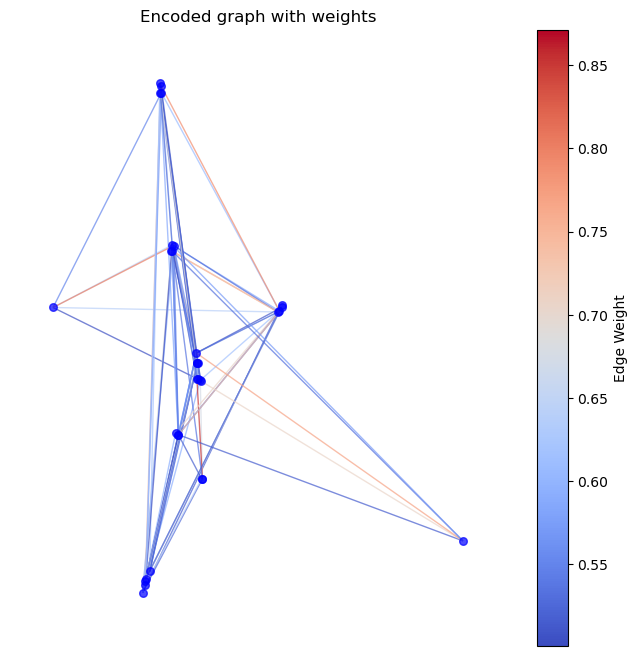

In [104]:
# Create a dictionary of node positions for the fully connected graph
pos7 = {node: (data['x'], data['y']) for node, data in encoded_graph.nodes(data=True)}

# Extract edge weights from the fully connected graph
edge_weights = nx.get_edge_attributes(encoded_graph, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    encoded_graph,
    pos7,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights),
    edge_vmax=max(edge_weights),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Encoded graph with weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [105]:
# Analyze the graph
graph_metrics = analyze_graph(encoded_graph)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

num_nodes: 32
num_edges: 89
density: 0.17943548387096775
is_directed: False
average_degree: 5.5625
degree_distribution: [5, 9, 4, 4, 7, 2, 4, 10, 2, 9, 8, 5, 8, 0, 3, 6, 7, 4, 12, 2, 4, 6, 7, 4, 8, 13, 4, 1, 8, 4, 3, 5]
degree_centrality: {(549360.0, 6330576.0): 0.16129032258064516, (555132.0, 6317792.0): 0.29032258064516125, (555308.0, 6318304.0): 0.12903225806451613, (555292.0, 6318128.0): 0.12903225806451613, (555588.0, 6318742.0): 0.22580645161290322, (558928.0, 6322894.0): 0.06451612903225806, (558981.0, 6322888.0): 0.12903225806451613, (555341.0, 6318418.0): 0.3225806451612903, (557255.0, 6324952.0): 0.06451612903225806, (557437.0, 6324871.0): 0.29032258064516125, (557426.0, 6324854.0): 0.25806451612903225, (558870.0, 6327287.0): 0.16129032258064516, (563949.0, 6330413.0): 0.25806451612903225, (564139.0, 6330707.0): 0.0, (564096.0, 6330582.0): 0.0967741935483871, (558845.0, 6327312.0): 0.1935483870967742, (563847.0, 6330375.0): 0.22580645161290322, (558649.0, 6328099.0): 0.129032

/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_2274/797967327.py:59: RuntimeWarning: divide by zero encountered in log
  power_law_fit = np.polyfit(np.log(range(1, len(degrees) + 1)), np.log(sorted(degrees, reverse=True)), 1)
